<a href="https://colab.research.google.com/github/Hadrien-Cornier/cool-nn-stuff/blob/main/product_of_betas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is the distribution of the product of 2 Beta variables ?

While the Beta distribution is well-understood, the distribution of the product of two independent Beta random variables is surprisingly complex and does not result in another Beta distribution.

Intuitively, one might expect the product to also follow a Beta distribution due to the family's versatility in modeling proportions and probabilities. However, the multiplicative interaction of two Beta variables introduces complexities that lead to a distinct and less tractable distribution.

Mathematically, if $X \sim Beta(\alpha_1, \beta_1)$ and $Y \sim Beta(\alpha_2, \beta_2)$ are independent, the probability density function (PDF) of their product, $Z = XY$, does not have a closed-form expression in terms of elementary functions.

This problem has been studied in detail, and one notable reference is the paper:

"THE DISTRIBUTION OF PRODUCT OF INDEPENDENT BETA RANDOM VARIABLES WITH APPLICATION TO MULTIVARIATE ANALYSIS" by R. P. Bhargava and C. G. Khatri (Received Mar. 8, 1978; revised Feb. 12, 1981)

In this paper, the authors derive expressions for the moments of the product distribution and explore its applications in multivariate analysis.

The challenge in characterizing the product distribution arises from the integral involved in calculating its PDF, which involves the product of two Beta PDFs. This integral does not have a simple closed-form solution, leading to the need for approximations or numerical methods to study the distribution's properties.

Enter a1 for Beta1: 4
Enter b1 for Beta1: 10
Enter a2 for Beta2: 2
Enter b2 for Beta2: 10


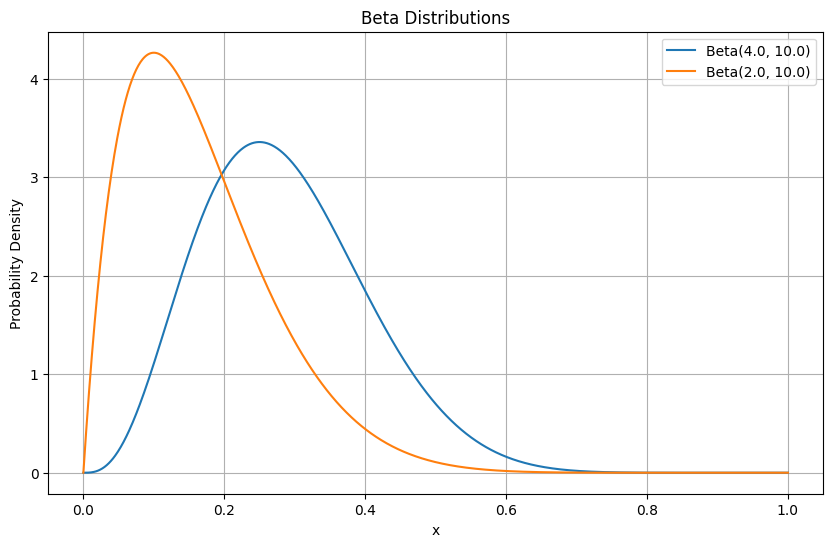

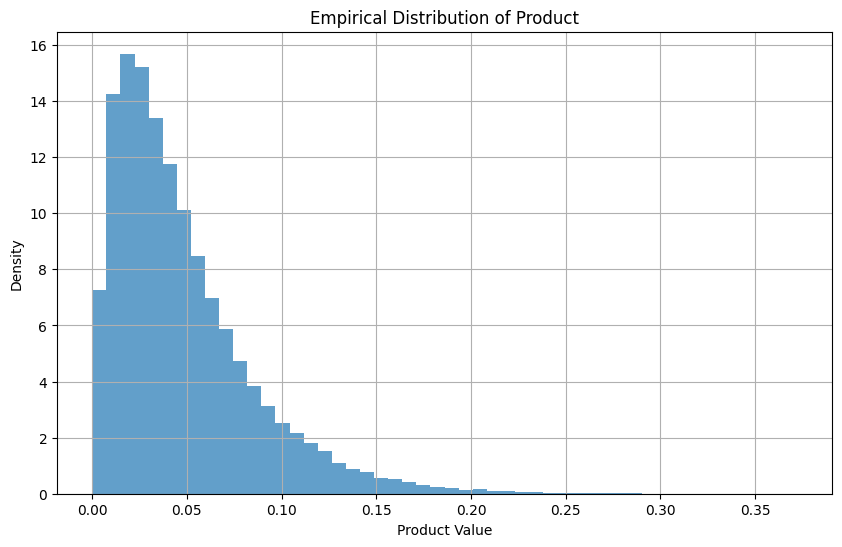

Mean of product: 0.0477
Variance of product: 0.0014


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpy as np

# Set up JAX to use 64-bit precision
jax.config.update("jax_enable_x64", True)

def plot_beta_distributions(a1, b1, a2, b2):
    x = np.linspace(0, 1, 1000)
    y1 = jax.scipy.stats.beta.pdf(x, a1, b1)
    y2 = jax.scipy.stats.beta.pdf(x, a2, b2)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label=f'Beta({a1}, {b1})')
    plt.plot(x, y2, label=f'Beta({a2}, {b2})')
    plt.title('Beta Distributions')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def sample_and_compute_product(key, a1, b1, a2, b2, num_samples):
    key, subkey1, subkey2 = random.split(key, 3)
    samples1 = random.beta(subkey1, a1, b1, (num_samples,))
    samples2 = random.beta(subkey2, a2, b2, (num_samples,))
    product_samples = samples1 * samples2
    return product_samples

def plot_product_distribution(product_samples):
    plt.figure(figsize=(10, 6))
    plt.hist(product_samples, bins=50, density=True, alpha=0.7)
    plt.title('Empirical Distribution of Product')
    plt.xlabel('Product Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# Main program
if __name__ == "__main__":
    # Input parameters
    a1 = float(input("Enter a1 for Beta1: "))
    b1 = float(input("Enter b1 for Beta1: "))
    a2 = float(input("Enter a2 for Beta2: "))
    b2 = float(input("Enter b2 for Beta2: "))

    # Plot the beta distributions
    plot_beta_distributions(a1, b1, a2, b2)

    # Sample and compute product
    num_samples = 100000
    key = random.PRNGKey(0)
    product_samples = sample_and_compute_product(key, a1, b1, a2, b2, num_samples)

    # Plot the product distribution
    plot_product_distribution(product_samples)

    # Print some statistics
    print(f"Mean of product: {jnp.mean(product_samples):.4f}")
    print(f"Variance of product: {jnp.var(product_samples):.4f}")

The goal is to get the estimate of the variance of the product of two betas using a simple technique with neural networks, without having to write any math!! Galaxy Brain

![Image Description](https://drive.google.com/uc?export=view&id=1sQpgAZg6iFRMVydRXJrXofDQidfn-0nf)

In [ ]:
# 5 STEPS

# 1 simulate many draws of parameters alpha and beta for  beta distributions
# 2 for each draw sample multiple points from that distribution
# 3 Now select at random two of the distributions and use their sampled points
# to then compute the empirical variance of the product of 2 of the dsistributiopns
# 4 this empirical variance serves as a label for training a neural network to
# predict the variance of the product of 2 betas as a function of the alpha,beta
# parameters of the two distributions
# essentially the neural network should learn the complex relationship between
# the parameters a beta distributions and the variance of their product
# 5 Right nopw we are looking at the product for 2 betas but we can then
# extend it to the raio of two betas and then any combination of divisions
#  and mnultiplications of beta distributions, either 2 by 2 or even we could
#  learn a neural network that takes in all the alphas and betas of all the
# distributions in the ranking function and
# produces an estimate of the corresponding variance

# STEP 1 : DRAW MULTIPLE BETA DISTRIBUTIONS


TODO to improve:

the alphas and betas should represent counts of success failure for a population of bernouilli variables which have a wide range of latent probabilities.

So right now we fix the array of alphas and betas to keep moving on after the simulations but later we need to make sure we don't just pick arbitrary values but draw them according to some distribution that represents real world variation

In [3]:
import jax
import jax.numpy as jnp
from jax import random

def simulate_beta_draws(key, N, αs, βs):
    """
    Simulate draws from beta distributions using JAX.

    Parameters:
    - key: JAX random key
    - N: Number of draws to simulate
    - αs: Array of alpha (α) parameters (counts of negative events)
    - βs: Array of beta (β) parameters (counts of positive events)

    Returns:
    - A matrix of shape (len(αs), N) with simulated beta draws
    """
    # Ensure αs and βs are JAX arrays
    αs = jnp.array(αs)
    βs = jnp.array(βs)

    # Generate random samples from beta distributions
    draws = random.beta(key, αs[:, None], βs[:, None], shape=(len(αs), N))

    return draws

# Example usage
key = random.PRNGKey(0)  # Initialize random key
N = 1000  # Number of draws to simulate
αs = [5, 10, 15]  # Example alpha (α) parameters
βs = [10, 5, 20]  # Example beta (β) parameters

# Simulate beta draws
beta_draws = simulate_beta_draws(key, N, αs, βs)

print(beta_draws)

[[0.15674376 0.31903094 0.3590962  ... 0.32214102 0.25923824 0.19612798]
 [0.72915846 0.81549716 0.66124135 ... 0.34493616 0.6185227  0.77668726]
 [0.42572734 0.36834726 0.57760274 ... 0.42392877 0.43996733 0.46230567]]


# STEP 2 : EMPIRICAL BETA PRODUCT SIMULATION

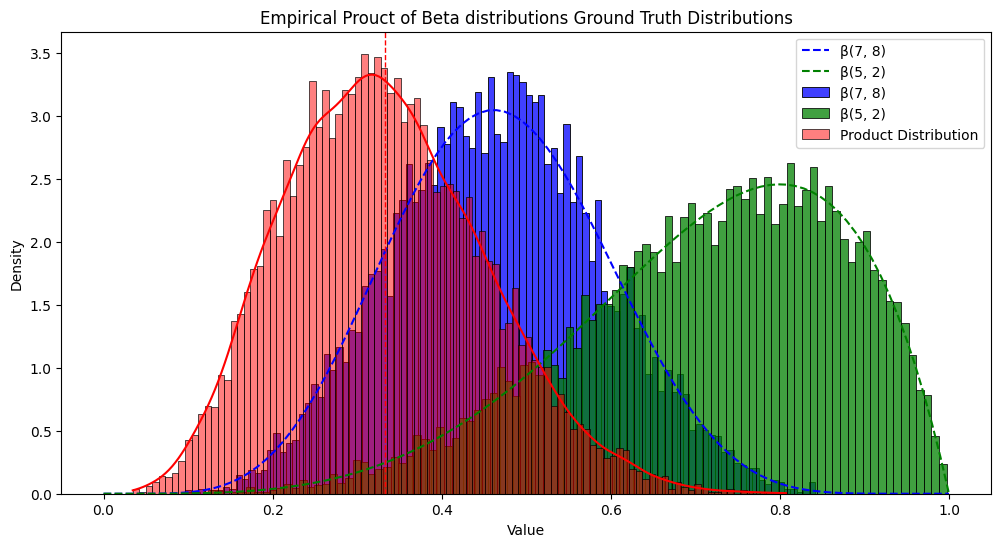

In [22]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, normal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# Parameters for the Beta distributions
αs = [7, 5]  # Example alpha parameters
βs = [8, 2]  # Example beta parameters

# Set the random seed for reproducibility
key = PRNGKey(0)

# Define the number of samples
N = 10000
bins = N // 100

# Generate samples from two Beta distributions
β_0 = beta.rvs(αs[0], βs[0], size=N, random_state=0)
β_1 = beta.rvs(αs[1], βs[1], size=N, random_state=1)

# Calculate the product of the samples
product_samples = β_0 * β_1

# Generate the ground truth Beta distribution values
x_values = jnp.linspace(0, 1, 100)
beta1_vals = beta.pdf(x_values, αs[0], βs[0])
beta2_vals = beta.pdf(x_values, αs[1], βs[1])

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot the first distribution with ground truth
sns.histplot(β_0, kde=False, color='blue', label=f"β{(αs[0],βs[0])}", stat='density', bins=bins)
plt.plot(x_values, beta1_vals, color='blue', linestyle='dashed', label=f"β{(αs[0],βs[0])}")

# Plot the second distribution with ground truth
sns.histplot(β_1, kde=False, color='green', label=f"β{(αs[1],βs[1])}", stat='density', bins=bins)
plt.plot(x_values, beta2_vals, color='green', linestyle='dashed', label=f"β{(αs[1],βs[1])}")

# Plot the product distribution
sns.histplot(product_samples, kde=True, color='red', label='Product Distribution', stat='density', bins=bins)
plt.axvline(jnp.mean(product_samples), color='red', linestyle='dashed', linewidth=1)

# Add labels and legend
plt.title('Empirical Product of Beta distributions Ground Truth Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()